In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

[PosixPath('raw_data/antisacadas_98.csv'),
 PosixPath('raw_data/antisacadas_91.csv'),
 PosixPath('raw_data/antisacadas_92.csv'),
 PosixPath('raw_data/antisacadas_99.csv')]

In [4]:
suj = 'antisacadas_91'
df = pd.read_csv(f'./raw_data/{suj}.csv')
df.head(5)

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,ip,user_agent,device,browser,browser_version,platform,platform_version,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,success,timeout,failed_images,failed_audio,failed_video,jspsych_start_time,load_time,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,validation-id,validation-point-id,last-estimations,validation-results,isSaccadeExperiment,typeOfSaccade,isTutorial,cueShownAtLeft,itiEnd,fixEnd,intraEnd,visualEnd,responseEnd,viewportWidth,viewportHeight,systemIsStillCalibrated,events
0,1006.0,"\n <div style=""left: calc(50% - 400px); wid...",0,html-button-response,0,1010,0.0-0.0,91,1,2023-02-07 20:55:05,ba99e1b51ad05fbf3d7a37345e407160,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7178.0,NaN,"{""anteojos"":""no"",""age"":""33"",""hand"":""derecha"",""...",survey-html-form,1,8193,0.0-1.0,91,1,2023-02-07 20:55:05,ba99e1b51ad05fbf3d7a37345e407160,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,709.0,"\n <div style=""left: calc(50% - 400px); wid...",0,html-button-response,2,8904,0.0-2.0,91,1,2023-02-07 20:55:05,ba99e1b51ad05fbf3d7a37345e407160,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46036.0,NaN,NaN,virtual-chinrest,3,54943,0.0-3.0,91,1,2023-02-07 20:55:05,ba99e1b51ad05fbf3d7a37345e407160,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,85.6,53.98,312.0,3.64,505.91,9.67142,32.26,52.076875,26.720397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5546.0,"\n <div style=""left: calc(50% - 400px); wid...",0,html-button-response,4,60493,0.0-4.0,91,1,2023-02-07 20:55:05,ba99e1b51ad05fbf3d7a37345e407160,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def pro_and_anti_plots(df):
    # Antisacadas
    df_antisacadas = df.query("not webgazer_data.isnull() and not typeOfSaccade == 'antisaccade'")

    webgazer_data_antisacadas = df_antisacadas['webgazer_data'].map(eval)
    for trial in range(len(df_antisacadas)):
        xs = [i['x'] for i in webgazer_data_antisacadas.iloc[trial]]
        ys = [i['y'] for i in webgazer_data_antisacadas.iloc[trial]]
        ts = [i['t'] for i in webgazer_data_antisacadas.iloc[trial]]
        plt.plot(ts, xs)

    plt.title(f'antisacadas\nN={len(webgazer_data_antisacadas)}\nsuj={suj}')
    plt.ylabel('x coordinate (pxs)')
    plt.xlabel('time (ms)')
    plt.show()

    # Prosacadas
    df_prosacadas = df.query("not webgazer_data.isnull() and not typeOfSaccade == 'prosaccade'")

    webgazer_data_prosacadas = df_prosacadas['webgazer_data'].map(eval)
    for trial in range(len(df_antisacadas)):
        xs = [i['x'] for i in webgazer_data_prosacadas.iloc[trial]]
        ys = [i['y'] for i in webgazer_data_prosacadas.iloc[trial]]
        ts = [i['t'] for i in webgazer_data_prosacadas.iloc[trial]]
        plt.plot(ts, xs)

    plt.title(f'Prosacadas\nN={len(webgazer_data_prosacadas)}\nsuj={suj}')
    plt.ylabel('x coordinate (pxs)')
    plt.xlabel('time (ms)')
    plt.show()

raw_data/antisacadas_98.csv
---------


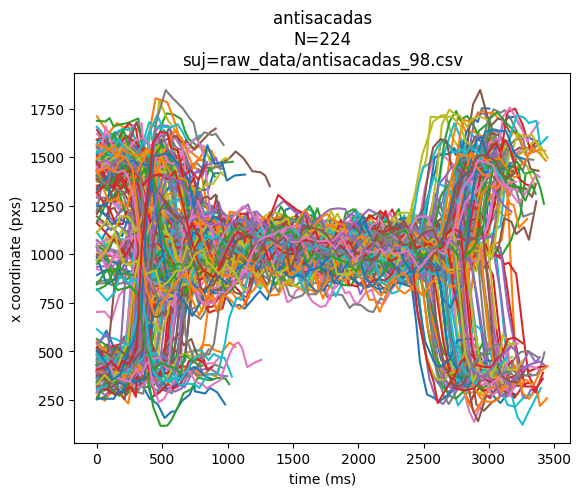

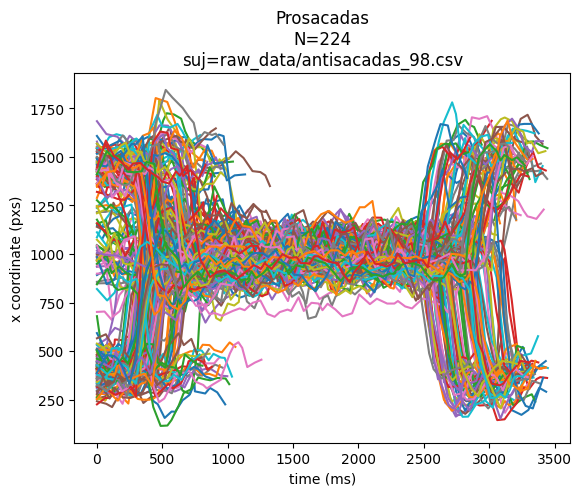

raw_data/antisacadas_91.csv
---------


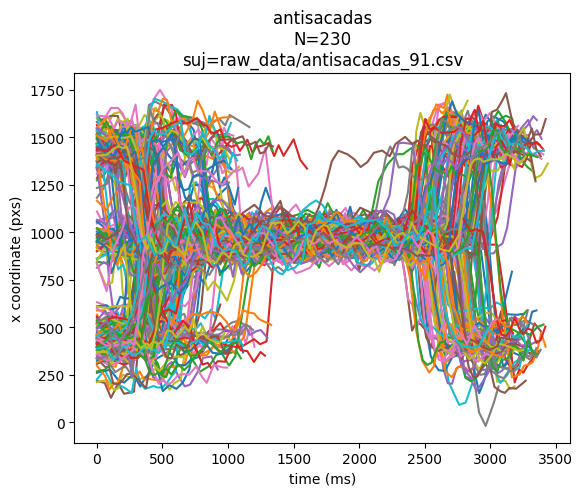

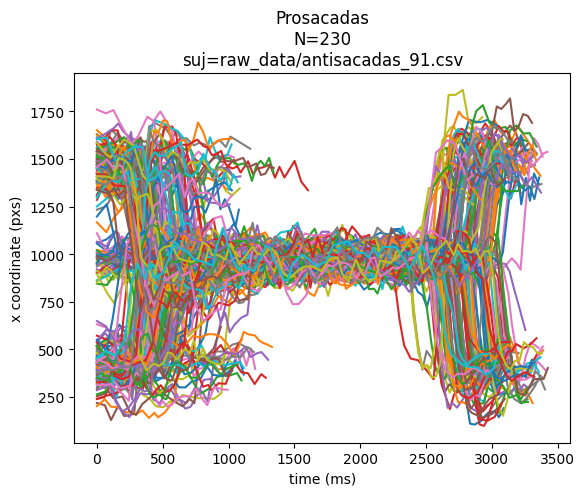

raw_data/antisacadas_92.csv
---------


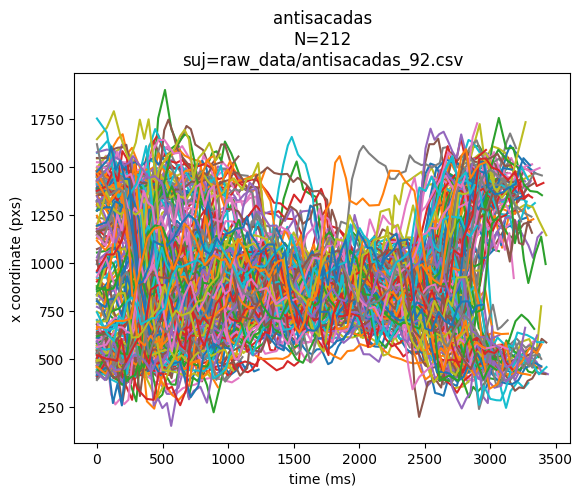

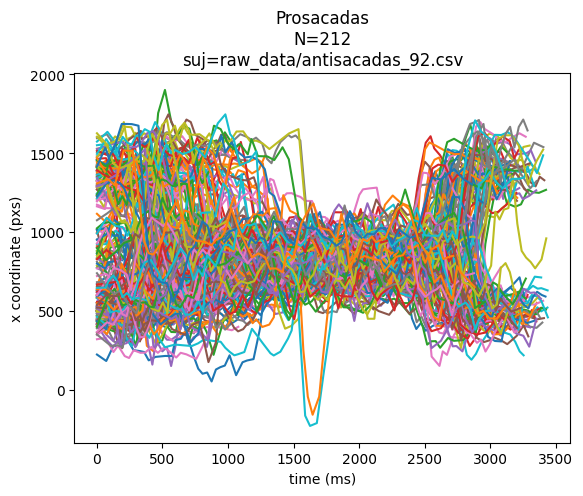

raw_data/antisacadas_99.csv
---------


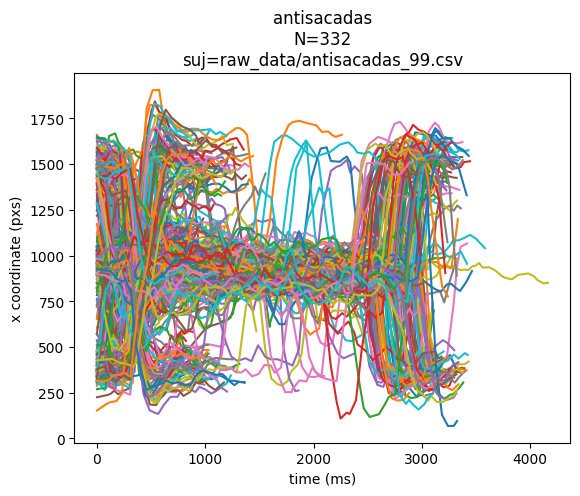

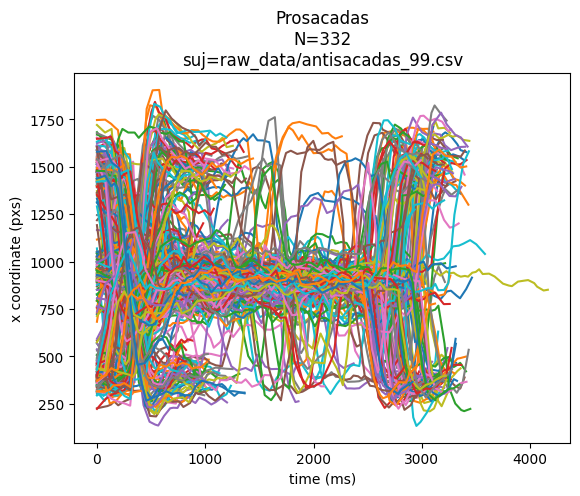

In [9]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
for suj in ALL_FILES_RAW:
    print(suj)
    print('---------')
    df = pd.read_csv(suj)
    pro_and_anti_plots(df)